<center>

*******************************************************************************************
    
### Two-dimensional Density Estimation

##### 14 December 2024

##### Juan Ignacio Mendoza Garay  

*******************************************************************************************

</center>

##### INFORMATION:

* Description:

    Find peaks of time-series signals, then compute their density preserving signal strength.
>
* Instructions:

    Edit the values indicated with an arrow like this: <---  
    Comment/uncomment or change values as suggested by the comments.  
    Run the program, close your eyes and hope for the best.  

*******************************************************************************************

In [49]:
import numpy as np
from scipy.ndimage import gaussian_filter1d
import scipy.signal as sgnl
import cv2
import matplotlib.pyplot as plt

#### Parameters for test:

In [50]:
n_series = 6 # <--- number of time-series
length_data = 10000 # <--- length of time-series

#### Make synthetic data and find their peaks:

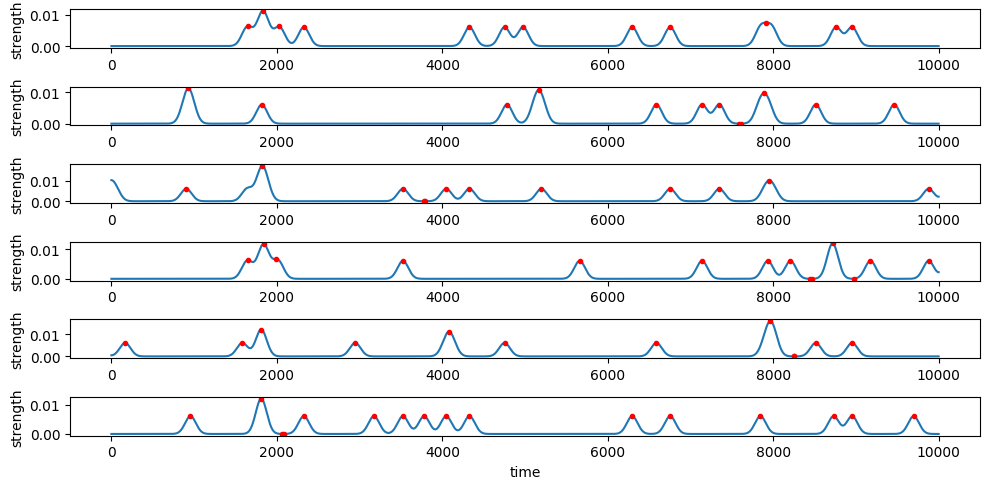

In [51]:
idx_peaks_mother = np.random.randint(1,length_data, np.random.randint(int(length_data/200),int(length_data/100)))
data_np = np.zeros((n_series,length_data))
pks_list = []
max_height = 0
for i_series in range(n_series):

    # make signal:
    idx_retain = np.random.randint(1,idx_peaks_mother.shape[0],int(idx_peaks_mother.shape[0]/4)) # retain 1/4 of the peaks
    idx_this = idx_peaks_mother[idx_retain]
    data_np[i_series,idx_this] = 1
    data_np[i_series,:] = gaussian_filter1d(data_np[i_series,:],int(length_data/150))
    
    # find peaks and their strength (height):
    idx_pks, pks_info = sgnl.find_peaks(data_np[i_series,:],height=0)
    pks_list.append([idx_pks, pks_info['peak_heights']])
    
    this_max = np.max(pks_list[i_series][1])
    if  this_max > max_height: max_height = this_max
    
plt.figure(figsize= (10,int(n_series/1.1)))
for i_series in range(n_series):
    plt.subplot(n_series,1,i_series+1)
    plt.plot(data_np[i_series,:])
    plt.plot(pks_list[i_series][0],pks_list[i_series][1],'.r')
    plt.ylabel('strength')
    if i_series == n_series-1: plt.xlabel('time')
plt.tight_layout()

***
### <center> Peak density and strength </center> 

#### Simple visualisation:

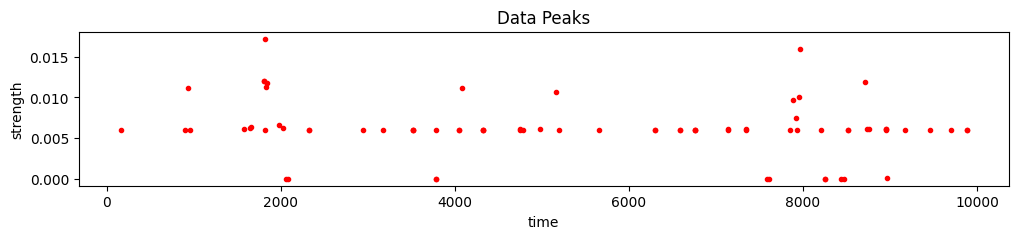

In [52]:
plt.figure(figsize=(12,2))
for i_series in range(n_series):
    plt.plot(pks_list[i_series][0],pks_list[i_series][1],'.r')
    plt.ylabel('strength')
    if i_series == n_series-1: plt.xlabel('time')
plt.title('Data Peaks');

#### Density-strength map:

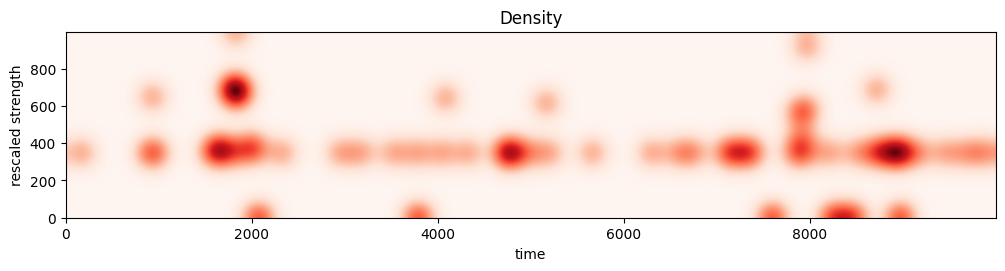

In [65]:
power_value = 1 # <--- the higher this number, the more distinct the density peaks
resolution = 1000 # <--- rows of the map's matrix
aspect_ratio = 0.5 # <--- adjust the aspect ratio

D_lbl = 'Density'
if power_value > 1: D_lbl = D_lbl + f'$^{power_value}$'
else: power_value = 1
    
density_np = np.zeros((resolution,length_data))
rescaling_factor = (resolution-1) / max_height 
for i_series in range(len(pks_list)):

    for i_peak in range(pks_list[i_series][1].shape[0]):

        y = int(pks_list[i_series][1][i_peak] * rescaling_factor)
        density_np[y, pks_list[i_series][0][i_peak] ] = 1 

kernel_length = resolution
sigma = kernel_length/8
kernel_length = int(kernel_length)
kernel_length_half = int(kernel_length/2)
x = np.linspace(-kernel_length_half,kernel_length_half,kernel_length)
xx, yy = np.meshgrid(x, x / aspect_ratio )
gauss_2D = 1. / (2. * np.pi * sigma**2) * np.exp(-(xx**2. / (2. * sigma**2.) + yy**2. / (2. * sigma**2.)))
gauss_2D = gauss_2D/gauss_2D.max()

ds_map_np = cv2.filter2D(density_np,-1,gauss_2D)**power_value

plt.figure(figsize=(12,4))
plt.imshow(ds_map_np,aspect=1/aspect_ratio,cmap='Reds')
plt.ylabel('rescaled strength')
plt.xlabel('time')
plt.gca().invert_yaxis();
plt.title(D_lbl);

Colour darkness corresponds to density.

#### Density-strength peaks:

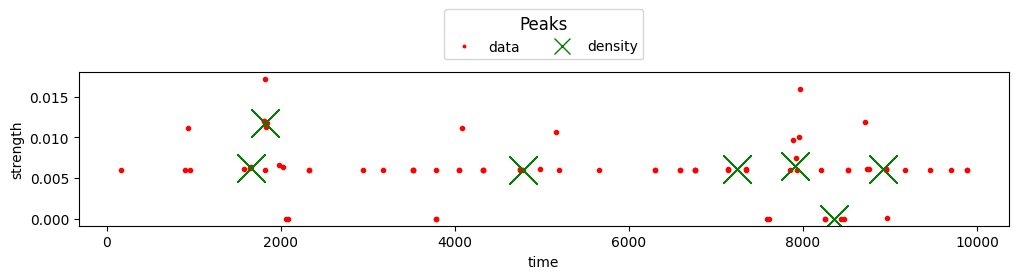

time , strength
----------------
1664 , 362
1824 , 684
4783 , 351
7244 , 352
7903 , 373
8353 , 0
8915 , 353


In [97]:
pks_thresh_std = 4 # <--- peaks' threshold in terms of standard deviations

ds_map_std_np = ds_map_np.copy()
ds_map_std_np[ ds_map_std_np < np.std(ds_map_std_np)*pks_thresh_std] = 0

diff_2D_np = np.zeros(ds_map_np.shape)
this_diff_np = np.zeros(ds_map_np.shape)
for i_axis in range(2):

        i_end_rows = this_diff_np.shape[0] + i_axis - 1
        i_end_cols = this_diff_np.shape[1] - i_axis
        this_diff_np[:i_end_rows,:i_end_cols] = np.diff(ds_map_std_np,1,axis=i_axis)
    
        this_diff_np[this_diff_np<0] = -1
        this_diff_np[this_diff_np>0] = 1
    
        i_start_rows = -i_axis + 1
        this_diff_np[i_start_rows:,i_axis:] = np.diff(this_diff_np,1,axis=i_axis)
        
        diff_2D_np[this_diff_np < 0] += 1
        
idx_pks_x, idx_pks_y = np.where( diff_2D_np.T == 2 )
idx_pks_y_original_scale = idx_pks_y / rescaling_factor

plt.figure(figsize=(12,2))
for i_series in range(n_series):
    plt.plot(pks_list[i_series][0],pks_list[i_series][1],'.r')
    plt.plot(idx_pks_x,idx_pks_y_original_scale,'xg',markersize=20)
    plt.ylabel('strength')
    if i_series == n_series-1: plt.xlabel('time')
d_lbl = 'density'
if power_value > 1:
    d_lbl = d_lbl + f'$^{power_value}$'
plt.legend( ['data',d_lbl],title='Peaks',title_fontsize='large',loc='upper center',ncols=2,markerscale=0.6,
            bbox_to_anchor=(0.5, 1.45) );
plt.show()

print('time , strength\n----------------')
for i in range(len(idx_pks_x)):
    print(f'{idx_pks_x[i]} , {idx_pks_y[i]}')